# Проект для «Викишоп»

__Заказчик__:  интернет-магазин «Викишоп».

__Описание задачи__

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

__Цель__: разработать модель для классификации комментариев на позитивные и негативные.

__Целевая метрика__: *F1* не меньше 0.75. 

__Описание данных__: Набор данных с разметкой о токсичности комментариев (`comment_toxicity_dataset.csv`). Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [ ]:
#!pip install -q contractions

In [ ]:
import re

import contractions
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
from lightgbm import LGBMClassifier
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

# константы
RANDOM_SEED = 57
RANDOM_STATE = 42

In [4]:
# для удаления стоп-слов
nltk.download('stopwords')
# для лемматизации
nltk.download('wordnet')
# для POS-тегирования
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Загрузка и обзор данных

In [ ]:
data = pd.read_csv('/datasets/comment_toxicity_dataset.csv')

In [6]:
data.sample(10)

,Unnamed: 0,text,toxic
125513,125642,So it both?\nCould animes be longer? —,0
137061,137199,Dick Merrill \n\nI think it was great of you t...,0
121568,121673,Please unblock .75 and .252. I can personally...,1
137030,137168,"""\n Sorry, I overlooked a miniscule """"cc-by-sa...",0
116902,117001,As long as this encyclopedia is administered b...,0
20579,20599,We should not include house of lords since the...,0
145759,145915,"""\n\nRegarding edits made during October 28 20...",0
23583,23603,April 2013\nSorry. Won't happen again. I'm n...,0
132082,132218,One more history merge \n\nDear Mark:\n\nIf yo...,0
42961,43011,"""\n\nWikipedia is supposed to be non-partial. ...",0


In [7]:
data = data.drop('Unnamed: 0', axis=1)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [9]:
data['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

In [10]:
data.duplicated().sum()

0

Мы загрузили данные - 159 292 записей, пропусков и дубликатов нет. Лишний столбец (содержащий индексы) удалили. Типы данных определены верно. Всего 10% из комментариев отмечены как токсичные. Наблюдаем дисбаланс классов в таргете.

### Очистка и лемматизация текста

In [11]:
def clear_text(text):

    text = contractions.fix(text)
    text = text.lower()
    pattern = r"[^a-z'\s]"
    t = re.sub(pattern, ' ', text)
    return ' '.join(t.split())

In [12]:
data['prepared_data'] = data['text'].apply(clear_text)
data['prepared_data'].head()

0    explanation why the edits made under my userna...
1    d'aww he matches this background colour i am s...
2    hey man i am really not trying to edit war it ...
3    more i cannot make any real suggestions on imp...
4    you sir are my hero any chance you remember wh...
Name: prepared_data, dtype: object

Приведем слова к начальной форме - лемме.

In [13]:
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

In [14]:
lemmatizer = WordNetLemmatizer()
data['prepared_data'] = data['prepared_data'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word, pos=penn2morphy(tag)) for word, tag in pos_tag(word_tokenize(x))]))
data['prepared_data'].head()

0    explanation why the edits make under my userna...
1    d'aww he match this background colour i be see...
2    hey man i be really not try to edit war it be ...
3    more i can not make any real suggestion on imp...
4    you sir be my hero any chance you remember wha...
Name: prepared_data, dtype: object

In [15]:
data.duplicated(subset=['prepared_data', 'toxic']).sum()

1274

In [16]:
data = data.drop_duplicates(subset=['prepared_data', 'toxic'])
data.shape

(158018, 3)

In [17]:
data['toxic'].value_counts(normalize=True)

0    0.898379
1    0.101621
Name: toxic, dtype: float64

После удаления дубликатов до и после лемматизации количество записей сократилось до 158018.

### Подготовка признаков

In [18]:
# выделим выборки с учетом страт
X_train, X_test, y_train, y_test = train_test_split(
    data['prepared_data'],
    data['toxic'].values, 
    test_size = 0.1, 
    random_state = RANDOM_STATE,
    shuffle=True,
    stratify = data['toxic'].values)

In [19]:
# получение стоп-слов для дальнейшего использования в векторайзере
stop_words = set(stopwords.words('english'))

## Обучение

In [20]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, max_features=10000)),
    ('model', LogisticRegression())
])

param_grid = [
    {
        'model': [LogisticRegression(solver='saga')],
        'model__C': [1, 10, 100],
        'model__class_weight': [None, 'balanced']
    },
    {
        'model': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'model__n_estimators': [100, 300],
        'model__max_depth': [5, 10, 15],
        'model__class_weight': [None, 'balanced']
    },
    {
        'model': [LGBMClassifier(random_state=RANDOM_STATE)],
        'model__num_leaves': [16, 32],
        'model__n_estimators': [300, 400],
        'model__max_depth': [8, 10]
    },
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': [5, 10],
        'model__class_weight': [None, 'balanced'],
        'model__min_samples_split': [2, 5]
    }
]

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# результаты
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f'Лучшая модель и ее параметры:{best_params}\nF1 на кросс-валидации:{best_score:.4f}')

Лучшая модель и ее параметры:{'model': LogisticRegression(C=10, solver='saga'), 'model__C': 10, 'model__class_weight': None}
F1 на кросс-валидации:0.7683


In [21]:
results = pd.DataFrame(grid_search.cv_results_)

# посмотрим на топ-10
top_10 = results[
    ['rank_test_score', 'param_model', 'mean_test_score','params']
].sort_values(by='rank_test_score').head(10)

pd.set_option('display.max_colwidth', None)
top_10

,rank_test_score,param_model,mean_test_score,params
2,1,"LogisticRegression(C=10, solver='saga')",0.768343,"{'model': LogisticRegression(C=10, solver='saga'), 'model__C': 10, 'model__class_weight': None}"
24,2,LGBMClassifier(random_state=42),0.753511,"{'model': LGBMClassifier(random_state=42), 'model__max_depth': 10, 'model__n_estimators': 400, 'model__num_leaves': 16}"
25,3,LGBMClassifier(random_state=42),0.751160,"{'model': LGBMClassifier(random_state=42), 'model__max_depth': 10, 'model__n_estimators': 400, 'model__num_leaves': 32}"
4,4,"LogisticRegression(C=10, solver='saga')",0.749720,"{'model': LogisticRegression(C=10, solver='saga'), 'model__C': 100, 'model__class_weight': None}"
20,5,LGBMClassifier(random_state=42),0.747207,"{'model': LGBMClassifier(random_state=42), 'model__max_depth': 8, 'model__n_estimators': 400, 'model__num_leaves': 16}"
21,6,LGBMClassifier(random_state=42),0.745004,"{'model': LGBMClassifier(random_state=42), 'model__max_depth': 8, 'model__n_estimators': 400, 'model__num_leaves': 32}"
22,7,LGBMClassifier(random_state=42),0.744631,"{'model': LGBMClassifier(random_state=42), 'model__max_depth': 10, 'model__n_estimators': 300, 'model__num_leaves': 16}"
23,8,LGBMClassifier(random_state=42),0.743157,"{'model': LGBMClassifier(random_state=42), 'model__max_depth': 10, 'model__n_estimators': 300, 'model__num_leaves': 32}"
0,9,"LogisticRegression(C=10, solver='saga')",0.739538,"{'model': LogisticRegression(C=10, solver='saga'), 'model__C': 1, 'model__class_weight': None}"
18,10,LGBMClassifier(random_state=42),0.736145,"{'model': LGBMClassifier(random_state=42), 'model__max_depth': 8, 'model__n_estimators': 300, 'model__num_leaves': 16}"


Нужное значение метрики удается достигнуть только при использовании логистической регрессии и LGBMClassifier.

In [22]:
# оценка лучшей модели на тестовых данных
y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Test F1 Score: {f1:.4f}")

Test F1 Score: 0.7887


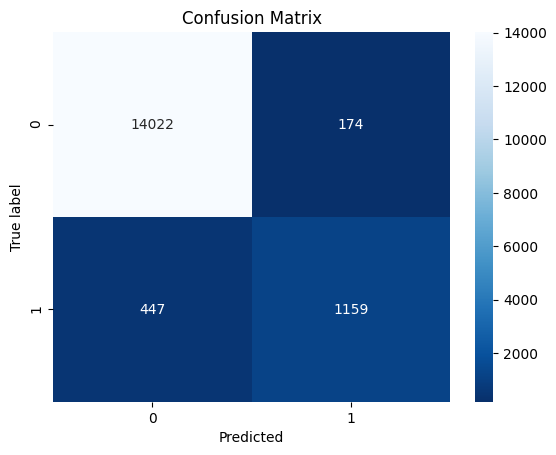

In [23]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Промежуточный вывод: 

Лучший результат показала модель логистической регрессии с параметрами 'C': 10, 'solver': 'saga', 'class_weight': None, метрика F1 на кросс-валидации - 0.77, на тестовой выборке - 0.79.

Модель редко определяет позитивные комментарии как негативные, т.е. сообщений, отправленных на модерацию по ошибке, не так много. Вместе с этим, большое число негативных комментариев пропущено, т.е. модель требует доработки.

## Выводы

Мы работали с датасетом, содержащим данные о токсичности правок. Только 10% комментариев были отмечены как токсичные. Мы очистили и лемматизировали текст, исключили стоп-слова, рассчитали TF-IDF. Обучили несколько моделей, лучшей оказалась модель логистической регрессии с параметрами 'C': 10, 'solver': 'saga', 'class_weight': None,  метрика F1 на кросс-валидации - 0.77, на тестовой выборке - 0.79. Требуемое значение целевой метрики достигнуто. Вместе с этим, при наличии ресурсов рекомендуется доработать модель, чтобы повысить ее способность выявлять негативные комментарии.